In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import block

X_path = "MNIST-5-6-Subset.txt"
Y_path = "MNIST-5-6-Subset-Labels.txt"

def load_mnist_data(path, reshape=None):
    with open(path, "r") as f:
        data = f.read().split()
    array = np.array(data, dtype=float)
    if reshape:
        array = array.reshape(reshape)
    return array   

# Konverter til float og numpy array
X = load_mnist_data(X_path, reshape=(784, 1877))
Y = load_mnist_data(Y_path, reshape=(-1))
X_light = load_mnist_data("MNIST-5-6-Subset-Light-Corruption.txt", reshape=(784, 1877))
X_moderate = load_mnist_data("MNIST-5-6-Subset-Moderate-Corruption.txt", reshape=(784, 1877))
X_heavy = load_mnist_data("MNIST-5-6-Subset-Heavy-Corruption.txt", reshape=(784, 1877))

print(X.shape)
print(Y.shape)


(784, 1877)
(1877,)


In [ ]:
# auxiliary functions

def _euclidean_dists(train, test):
    A = train.T
    B = test.T
    A2 = np.sum(A**2, axis=1, keepdims=True)
    B2 = np.sum(B**2, axis=1, keepdims=True).T
    return np.sqrt(A2 + B2 - 2 * (np.dot(A, B.T)))

def map_labels(labels, classes=None):
    labels = np.asarray(labels).reshape(-1)
    if classes is None:
        classes = np.unique(labels)
        if len(classes) != 2:
            raise ValueError("Kræver præcis to klasser, eller angiv classes=...")
    # map classes[0] -> -1, classes[1] -> +1
    return np.where(labels == classes[0], -1, 1).astype(int)


In [ ]:
# the KNN function

def knn(training_points, training_labels, test_points, test_labels):

    classes = np.unique(np.asarray(training_labels).reshape(-1))
    if len(classes) != 2:
        raise ValueError("Træningslabels skal have præcis to klasser.")
    # Map labels to -1 and 1
    y_train = map_labels(training_labels, classes=classes)
    y_test  = map_labels(test_labels,    classes=classes)
    # Compute distances between X_train and Y_test
    dists = _euclidean_dists(np.asarray(training_points), np.asarray(test_points))
    # Compare and sort the points which are closest
    order = np.argsort(dists, axis=0)
    # Get the labels of the nearest neighbors (1 or -1)
    neigh_labels = y_train[order]
    # Cumulative sum of votes for each K
    votes_cum = np.cumsum(neigh_labels, axis=0)
    # Predictions for all K (either positive (1) or negative (-1))
    preds_allK = np.sign(votes_cum)
    # Handle the case of a tie (0 votes) by predicting randomly
    preds_allK[preds_allK == 0] = np.random.choice([-1, 1], size=np.sum(preds_allK == 0))
    
    errors = (preds_allK != y_test[None, :]).mean(axis=1)

    return errors

In [ ]:
# prepare training data

m = 50
n_values = [10, 20, 40, 80]

X_train = X[:, :m]
Y_train = Y[:m].reshape(-1)

print(X_train.shape)
print(Y_train.shape)

(784, 50)
(50,)


In [ ]:
# validation sets function

def make_validation_sets(X, y, m, n, num_sets=5):
    sets_ = []
    for i in range(num_sets):
        start = m + i*n
        end   = m + (i+1)*n
        sets_.append((X[:, start:end], y[start:end]))
    return sets_

In [ ]:
# For each n, run the validation and plot the results of the KKN

def run_for_n_numpy(X, Y, X_train, Y_train, m, n, savefig=True):
    val_sets = make_validation_sets(X, Y, m, n)

    Ks = np.arange(1, m + 1)
    errors_all = []
    for (X_val, y_val) in val_sets:
        errs = knn(X_train, Y_train, X_val, y_val.reshape(-1))  # (m,)
        errors_all.append(errs)

    errors_all = np.stack(errors_all, axis=0)  # (5, m)

    # plot
    plt.figure(figsize=(7, 5))
    for i in range(errors_all.shape[0]):
        plt.plot(Ks, errors_all[i], label=f"Validation set {i+1}")
    plt.xlabel("K")
    plt.ylabel("Validation error")
    plt.title(f"Validation error vs K (n={n})")
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(f"validation_error_curves{n}.png", dpi=150)
        plt.close()
    else:
        plt.show()

    return Ks, errors_all

results = {}
for n in n_values:
    Ks, errors_all = run_for_n_numpy(X, Y, X_train, Y_train, m, n, savefig=True)
    results[n] = (Ks, errors_all)

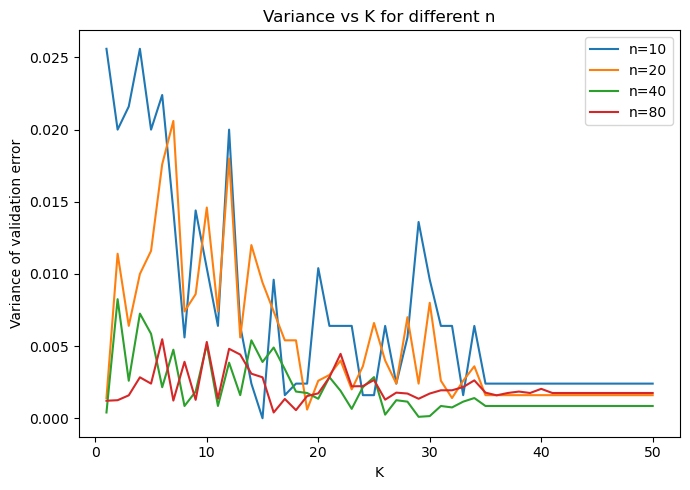

In [ ]:
# Plot variance vs K for different n

plt.figure(figsize=(7,5))
for n in n_values:
    Ks, errors_all = results[n]
    var_curve = np.var(errors_all, axis=0)
    plt.plot(Ks, var_curve, label=f"n={n}")
plt.xlabel("K")
plt.ylabel("Variance of validation error")
plt.title("Variance vs K for different n")
plt.legend()
plt.tight_layout()
plt.show()